In [9]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.utils.visualize import plot_voronoi
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point
from PIL import Image
import numpy as np

In [20]:
train_set = r"../data/Ki67/SHIDC-B-Ki-67/Train/p1_0308_3"
#train_set = r"../test_images/dots"
JSON_EXT = ".json"
JPG_EXT = ".jpg"
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120

In [99]:
def filter_polygons(polygon,img_shape):
    x = img_shape[0]
    y = img_shape[1]
    (miny, minx, maxy, maxx)=[int(item) for item in list(polygon.bounds)]
    if minx <= -1 or maxx > x:
        return False
    if miny <= -1 or maxy > y:
        return False
    return True

def get_regions(image_name):
    fig, ax = plt.subplots()
    json_path = image_name+JSON_EXT

    json_df = pd.read_json(json_path)

    cell_points = list(zip(json_df.x,json_df.y))
    vor = Voronoi(cell_points)
    polygons = []
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    plot_voronoi(vor,img_arr,show_points=True,show_verticles=False,line_width=0.3)
    for idx ,region in enumerate(vor.regions):
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            x = Polygon(polygon)
            if x.is_empty:
                continue
            
            if filter_polygons(x,img_arr.shape):
                polygons.append(x)
                plt.fill(*zip(*polygon))
    
    return polygons


In [100]:
def plot(image_name):
    json_path = image_name+JSON_EXT

    json_df = pd.read_json(json_path)
    cell_points = list(zip(json_df.x,json_df.y))
    vor = Voronoi(cell_points)
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    plot_voronoi(vor,img_arr,show_points=True,show_verticles=False,line_width=0.3)
    #plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()

In [ ]:

def plot_arr(img_arr):
    fig, ax = plt.subplots()
    ax.imshow(img_arr)
   # ax.set_ylim([0, 180])
   # ax.set_xlim([0, 180])
   # plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    return fig


In [97]:
def get_pixels(image_name,polygon,plot=False):
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    
    #plot_arr(img_arr)
    #print(img_arr.shape)
    
    (miny, minx, maxy, maxx)=[int(item) for item in list(polygon.bounds)]
   # print(polygon.bounds)
    shape = img_arr.shape
    x_range = range(minx,maxx)
    y_range = range(miny,maxy)
    if plot:
        test = np.copy(img_arr)
    mask = np.copy(img_arr[minx:maxx,miny:maxy])
    for x in x_range:
        for y in y_range:
            p = Point(y,x)
            if not polygon.contains(p):
                if plot:
                    test[x,y]=test[x,y]*[255,0,0]
                mask[x-minx,y-miny]=mask[x-minx,y-miny]*[0,0,0]
    #
    if plot:
        plot_arr(test)
        plot_arr(mask)
    return mask

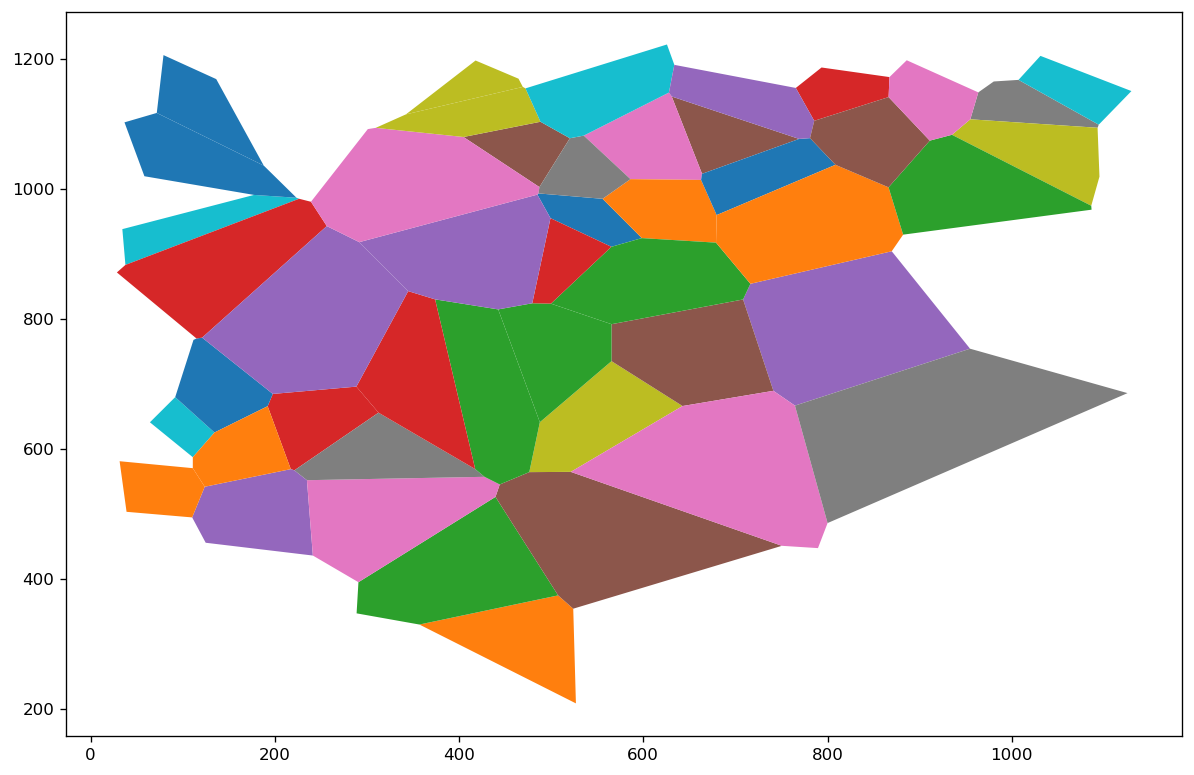

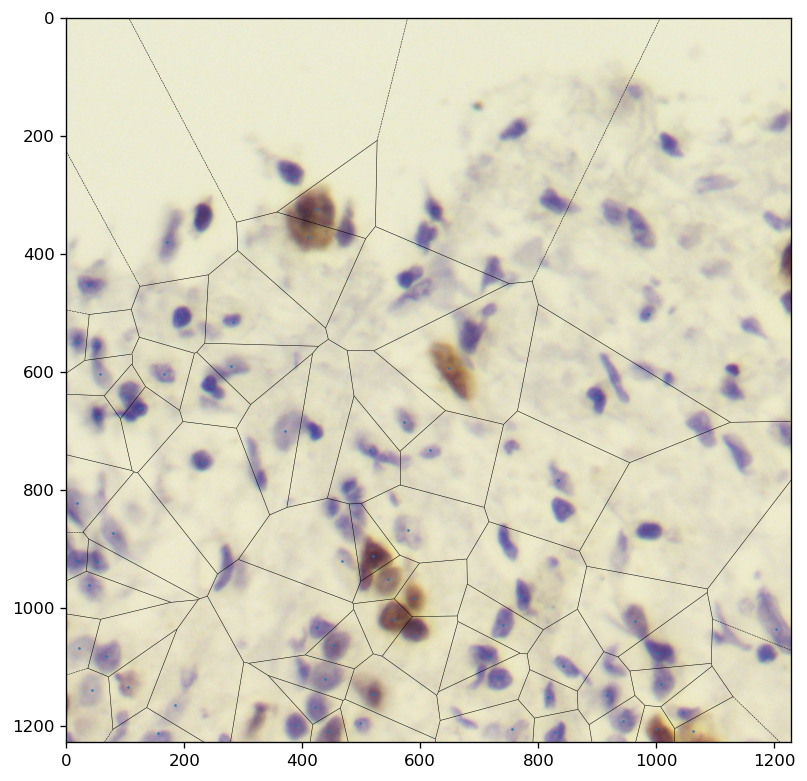

In [98]:
polygons = get_regions(train_set)

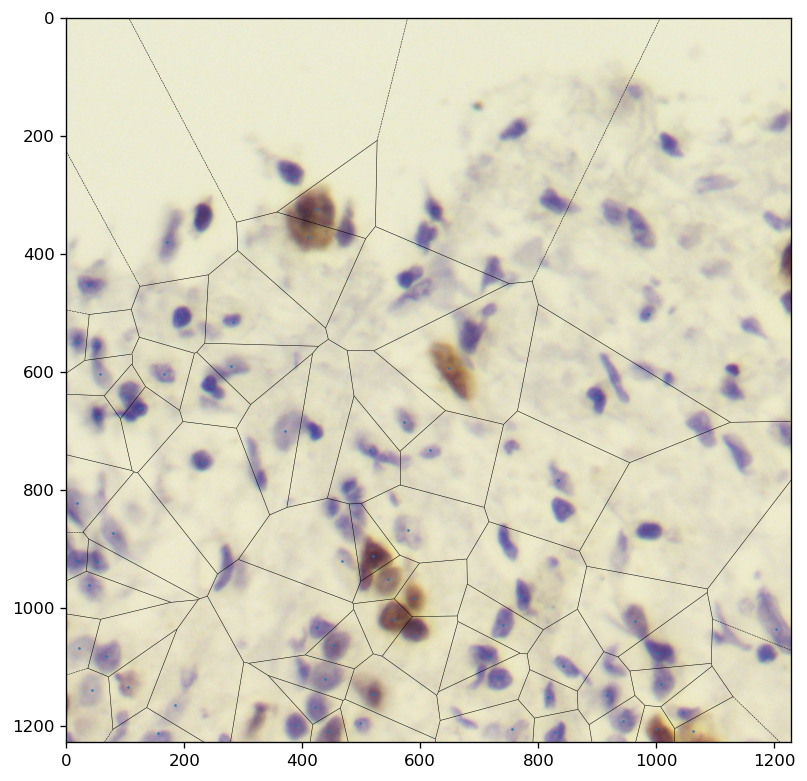

In [53]:
plot(train_set)

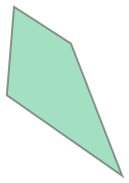

In [54]:
polygons[0]

(71.9011117612639, 1035.9403491755577, 188.0043646944714, 1205.975561687032)


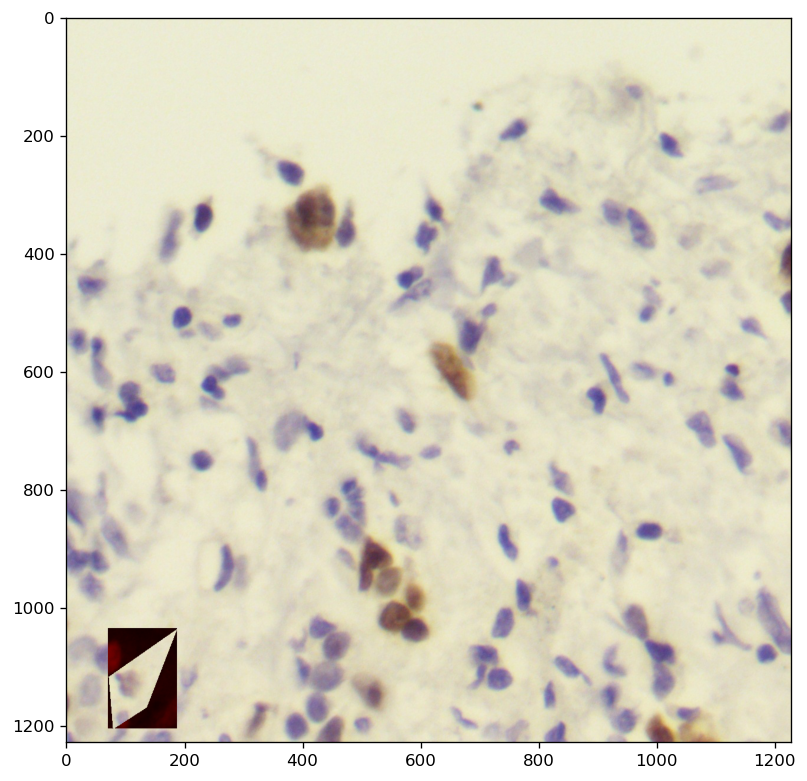

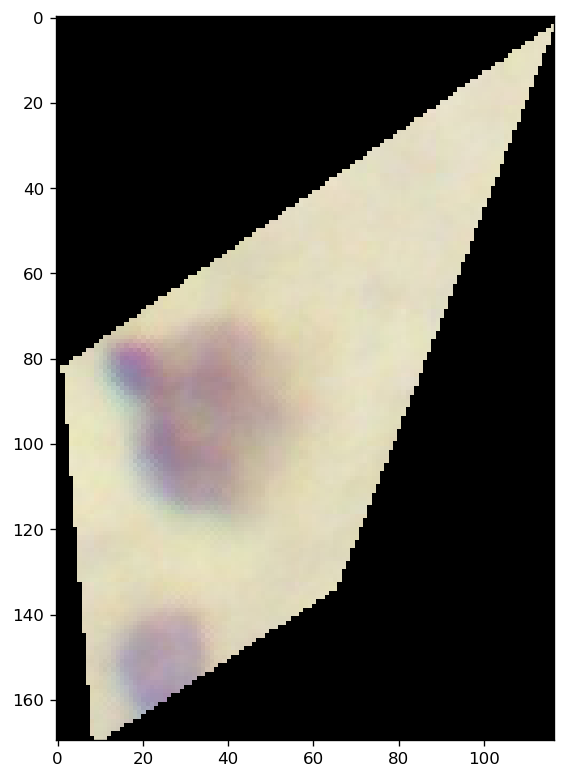

In [56]:
x = get_pixels(train_set,polygons[0],True)

In [58]:
len(polygons)

47